Supplementary notebook to the manuscript "Unifying thermochemistry concepts in computational heterogeneous catalysis", by Dr. Bjarne Kreitz (Brown University), Dr. Gabriel Gusmao (Georgia Tech), Dr. David H. Bross (Argonne National Laboratory), Dingqi Nai (Georgia Tech), Jagriti Sahoo (Georgia Tech), Dr. C. Franklin Goldsmith (Brown University), Dr. Andrew J. Medford (Georgia Tech). 

Correspondence to Bjarne Kreitz (bjarne_kreitz@brown.edu) and Andrew J. Medford (ajm@gatech.edu)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from scipy import linalg

eV_to_kJmol=96.485

# Converting between reaction enthalpies and formation enthalpies

The reaction enthalpies calculated from the total DFT energies are conserved when using an atomic reference basis set, regardless of the choice of anchor/reference species. 
We can use this fact and calculate EOFs if only reaction enthalpies are reported for a mechanism.
This problem cannot be formulated for a single species, and it directly becomes a linear algebra problem. 
For a chemical kinetics network involving $n$ chemical species, a total of $n_a+n_s$ reference species must be defined, where $n_a$ is the number of unique atomic elements of which all species consist and $n_s$ is the number of surface sites (typically one). 
Let $\mathbf{\underline{E}}$ be the zero-point corrected energies of chemical species, $\mathbf{\underline{H}}^{A}_{f}$ be the EOFs of the same species given defined references $A$ and $\mathbf{\underline{H}}_{r}$ be the reaction energies according to the stoichiometry matrix $\mathbf{\underline{\underline{S}}}$.
The stoichiometry matrix $\mathbf{\underline{\underline{S}}}$ contains the stoichiometric numbers of the reactants and products, which are positive for products and negative for reactants (see SI). 
The relationship between $\mathbf{\underline{H}}_{r}$ and $\mathbf{\underline{E}}$ is a simple linear combination,

\begin{equation}
\mathbf{\underline{H}}_{r}=\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{H}}_{f}=\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{E}}
\end{equation}

Since the number of elementary reactions is typically greater than or equal to the number of chemical species, i.e., $m\ge n$, there exists a direct mapping between $\mathbf{\underline{E}}$ and $\mathbf{\underline{H}}_{r}$.
Yet, no obvious mapping exists in the opposite direction since this is an under-constrained linear system of equations. 
The Moore-Penrose pseudo-inverse of the stoichiometry matrix $\mathbf{\underline{\underline{S}}}^+$ can be used to construct the inverse mapping. 
To solve this inverse mapping, it is first necessary to select anchor species for each element from the mechanism, e.g., $A= C_2H_6, CO, H_2O, Pt(111)$.
We can separate the stoichiometry matrix $\mathbf{\underline{\underline{S}}}$ into the anchor species $\mathbf{\underline{\underline{S}}}^{A}$ and non-anchor species $\mathbf{\underline{\underline{\hat{S}}}}$, leading to

\begin{equation}
\mathbf{\underline{H}}_{r}=\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{H}}_{f}=\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\mathbf{\underline{\hat{H}}}_{f}+\mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}
\end{equation}

In this equation, we separate $\mathbf{\underline{H}}_{f}$ into the anchor species $\mathbf{\underline{H}}^{A}_{f}$ and the unknown EOFs $\mathbf{\underline{\hat{H}}}_{f}$. 
All EOFs are referenced to the DFT energies of the anchor species. 
Thus, the EOFs of the anchor species $\mathbf{\underline{H}}^{A}_{f}$ are 0.  
We can now rearrange the equation to compute the unknown EOFs from the reaction enthalpies referenced to the set of anchor species. 

\begin{align}
\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{\hat{H}}}_{f} &=\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\mathbf{\underline{\hat{H}}}_{f}+\mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}\\
     \mathbf{\underline{\hat{H}}}^{A}_{f} & = \left(\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\right)^+ \left(\mathbf{\underline{H}}_{r} -  \mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}\right)\\
      \mathbf{\underline{\hat{H}}}^{A}_{f} & = \left(\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\right)^+\left(\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{E}} - \mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}\right)
\end{align}

We start by constructing the matrix of stoichiometric matrix $\mathbf{\underline{\underline{S}}}$.

In [37]:
# Stoichiometry of each elementary reaction in the mechanism
reactions = [
    {"X": -1, "C2H6": -1, "C2H6X": 1},        
    {"X": -1, "CO2": -1, "CO2X": 1},                     
    {"X": -1, "C2H6X": -1, "XH": 1, "XCH2CH3": 1},   
    {"X": -1, "XCH2CH3": -1, "XH": 1, "XCH2XCH2": 1},
    {"X": -1, "CO2X": -1, "XCO": 1, "XO":1},
    {"XO": -1, "XH": -1, "X": 1, "XOH": 1},            
    {"XOH": -1, "XH": -1, "H2OX": 1, "X": 1},            
    {"H2OX": -1, "H2O": 1, "X": 1},                      
    {"XCO": -1, "CO": 1, "X": 1},                  
    {"XCH2XCH2": -1, "C2H4": 1, "X":1},         
]

#Species in the reaction mechanism
species = ['CO2', 'C2H4', 'C2H6X', 'XCH2CH3', 'XO', 'XCH2XCH2', 'XCO', 
           'CO2X', 'XOH', 'H2OX', 'XH', 'X', 'C2H6','H2O', 'CO']
#the last for species will be our reference species

# Creating the stoichiometry matrix
S = np.zeros((len(species), len(reactions)))

# Filling the matrix
for j, reaction in enumerate(reactions):
    for reactant, stoich_coeff in reaction.items():
        i = species.index(reactant)
        S[i, j] = stoich_coeff
        
S

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

We can then calculate the enthalpies of reaction from the BEEF-vdW DFT energies

\begin{equation}
\mathbf{\underline{H}}_{r}=\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{H}}_{f}
\end{equation}


In [38]:
#We use the BEEF-vdW DFT energies to calculate the reaction enthalpies for the reactions above
species_energies = {
    "X": -377616.072,
    "C2H6": -615.3019939,
    "H2O": -611.0186083,
    "CO2": -1414.682864,
    "C2H6X" : -378231.5655,
    "XCH2CH3": -378214.9168,
    "XO": -378193.2832,
    "XCH2XCH2": -378198.4442,  
    "XCO": -378453.0261, 
    "CO2X": -379030.8164,
    "XOH": -378209.8045,
    "H2OX": -378227.2801,    
    "XH": -377632.6636,
    "CO": -835.5389907,
    "C2H4":-581.44565067567,   
}

#Sort the species energies according to the defined species list
E = np.array([species_energies[_]*eV_to_kJmol for _ in species])

#Calculate the enthalpies of formation
Hr=S.T.dot(E)
Hr

array([-18.47746606,  -5.93730097,   5.5092935 , -11.48171501,
        55.87446348,   6.78289551, -85.29273999,  18.28310668,
       136.53682082,  89.39811156])

We select anchor species for each element from the mechanism, in this case $A= C_2H_6, CO, H_2O, Pt(111)$. Since we are creating a local thermochemical network in the DFT energy reference frame, we set the enthalpies of formation of these anchor species to 0. 

In [39]:
# Enthalpies of formation of the reference species are assumed to be zero

Hf_A_dict = {
    "X": 0,
    "C2H6": 0,
    "H2O": 0,
    "CO":0,
}

ref_species=Hf_A_dict.keys()

#Remove the reference species from the row space
S_A=S[-4:] # these are the reference species
S_hat=S[0:-4] # this is the rest of the stoichiometry matrix

#Array of the enthalpies of formation of the anchor species
Hf_A =  np.array( [Hf_A_dict[_] for _ in Hf_A_dict.keys()])
Hf_A

array([0, 0, 0, 0])

We can then determine the enthalpies of formation of the target species via 

\begin{align}
      \mathbf{\underline{\hat{H}}}^{A}_{f} & = \left(\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\right)^+\left(\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{E}} - \mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}\right)
\end{align}


In [40]:
#Calculate the enthalpies of formation of the target species using the pseudo-inverse
Hf= np.linalg.pinv(S_hat.T).dot(Hr-S_A.T.dot(Hf_A))

targets=species-ref_species

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: Hf[i] for i in range(len(targets))}
#Append the enthalpies of formation of the reference species to the enthalpies of formation dictionary
enthalpies_of_formation.update(Hf_A_dict)
enthalpies_of_formation

{'CO2': -103.51924771423782,
 'C2H4': 87.67622179997441,
 'C2H6X': -18.4774660616313,
 'XCH2CH3': -1.6041736579411054,
 'XO': 82.95473561961573,
 'XCH2XCH2': -1.7218897594761415,
 'XCO': -136.53682081535223,
 'CO2X': -109.45654867942767,
 'XOH': 78.37363221796271,
 'H2OX': -18.283106676492075,
 'XH': -11.363998907081395,
 'X': 0,
 'C2H6': 0,
 'H2O': 0,
 'CO': 0}

In [41]:
# Stoichiometry of each elementary reaction in the mechanism
reactions = [
    {"X": -1, "C2H6": -1, "C2H6X": 1},        
    {"X": -1, "CO2": -1, "CO2X": 1},                     
    {"X": -1, "C2H6X": -1, "XH": 1, "XCH2CH3": 1},   
    {"X": -1, "XCH2CH3": -1, "XH": 1, "XCH2XCH2": 1},
    {"X": -1, "CO2X": -1, "XCO": 1, "XO":1},
    {"XO": -1, "XH": -1, "X": 1, "XOH": 1},            
    {"XOH": -1, "XH": -1, "H2OX": 1, "X": 1},            
    {"H2OX": -1, "H2O": 1, "X": 1},                      
    {"XCO": -1, "CO": 1, "X": 1},                  
    {"XCH2XCH2": -1, "C2H4": 1, "X":1},         
]

#Species in the reaction mechanism
species = ['CO','C2H4','C2H6X', 'XCH2CH3', 'XO', 'XCH2XCH2', 'XCO', 
           'CO2X', 'XOH', 'H2OX', 'XH', 'X', 'C2H6','H2O', 'CO2']
#the last for species will be our reference species

# Creating the stoichiometry matrix
S = np.zeros((len(species), len(reactions)))

# Filling the matrix
for j, reaction in enumerate(reactions):
    for reactant, stoich_coeff in reaction.items():
        i = species.index(reactant)
        S[i, j] = stoich_coeff
        
S

#We use the BEEF-vdW DFT energies to calculate the reaction enthalpies for the reactions above
species_energies = {
    "X": -377616.072,
    "C2H6": -615.3019939,
    "H2O": -611.0186083,
    "CO2": -1414.682864,
    "C2H6X" : -378231.5655,
    "XCH2CH3": -378214.9168,
    "XO": -378193.2832,
    "XCH2XCH2": -378198.4442,  
    "XCO": -378453.0261, 
    "CO2X": -379030.8164,
    "XOH": -378209.8045,
    "H2OX": -378227.2801,    
    "XH": -377632.6636,
    "CO": -835.5389907,
    "C2H4":-581.44565067567,   
}

#Sort the species energies according to the defined species list
E = np.array([species_energies[_]*eV_to_kJmol for _ in species])

#Calculate the enthalpies of formation
Hr=S.T.dot(E)
Hr

# Enthalpies of formation of the reference species are assumed to be zero
Hf_A_dict = {
    "X": 0,
    "C2H6":  -68.38,
    "H2O": -238.902,
    "CO2":-393.11,
}

ATcT = {
    "C2H4": 60.89,
    "CO":-113.8,
}

ref_species=Hf_A_dict.keys()

#Remove the reference species from the row space
S_A=S[-4:] # these are the reference species
S_hat=S[0:-4] # this is the rest of the stoichiometry matrix

#Array of the enthalpies of formation of the anchor species
Hf_A =  np.array( [Hf_A_dict[_] for _ in Hf_A_dict.keys()])
Hf_A

#Calculate the enthalpies of formation of the target species using the pseudo-inverse
Hf= np.linalg.pinv(S_hat.T).dot(Hr-S_A.T.dot(Hf_A))

targets=species-ref_species

#Create a dictionary with the results
enthalpies_of_formation_global = {species[i]: Hf[i] for i in range(len(targets))}
#Append the enthalpies of formation of the reference species to the enthalpies of formation dictionary
enthalpies_of_formation_global.update(Hf_A_dict)
enthalpies_of_formation_global.update(ATcT)
enthalpies_of_formation_global

{'CO': -113.8,
 'C2H4': 60.89,
 'C2H6X': -86.85746606163123,
 'XCH2CH3': -63.165662507947296,
 'XO': -142.31024208039625,
 'XCH2XCH2': -56.46486745948849,
 'XCO': -200.86259539769708,
 'CO2X': -399.0473009617847,
 'XOH': -153.7098566320432,
 'H2OX': -257.18510667649196,
 'XH': -18.182510057075245,
 'X': 0,
 'C2H6': -68.38,
 'H2O': -238.902,
 'CO2': -393.11}

In [42]:
# Define the species and their elemental compositions in a dictionary
references_compositions = {
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},
    "CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "X": {"C": 0, "H": 0, "O": 0, "X": 1},
}

references=list(references_compositions.keys())
num_elements=4
# Create a matrix to hold the elemental compositions of the reference species
num_references = len(references_compositions)
N_A = np.zeros((num_references, num_elements))

# Fill in the elemental composition matrix of the reference species
for s, composition in references_compositions.items():
    i = references.index(s)
    N_A[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N_A

np.linalg.inv(N_A)

# Define the species and their elemental compositions in a dictionary
species_compositions = {
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "XCH2CH3": {"C": 2, "H": 5, "O": 0, "X": 1},
    "XCH2XCH2": {"C": 2, "H": 4, "O": 0, "X": 1},
    #"CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "XOH": {"C": 0, "H": 1, "O": 1, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},
}

species=list(species_compositions.keys())

# Create a matrix to hold the elemental compositions of the target species
num_species = len(species_compositions)
num_elements = 4  # C, H, O, X
N = np.zeros((num_species, num_elements))

# Fill in the elemental composition matrix of the target species
for s, composition in species_compositions.items():
    i = species.index(s)
    N[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
M=N.dot(np.linalg.inv(N_A))
M

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.11022302e-16],
       [ 9.28571429e-01, -2.85714286e-01,  1.42857143e-01,
         2.14285714e-01],
       [ 8.57142857e-01, -5.71428571e-01,  2.85714286e-01,
         4.28571429e-01],
       [-7.14285714e-02,  7.14285714e-01,  1.42857143e-01,
         2.14285714e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.11022302e-16]])

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid e

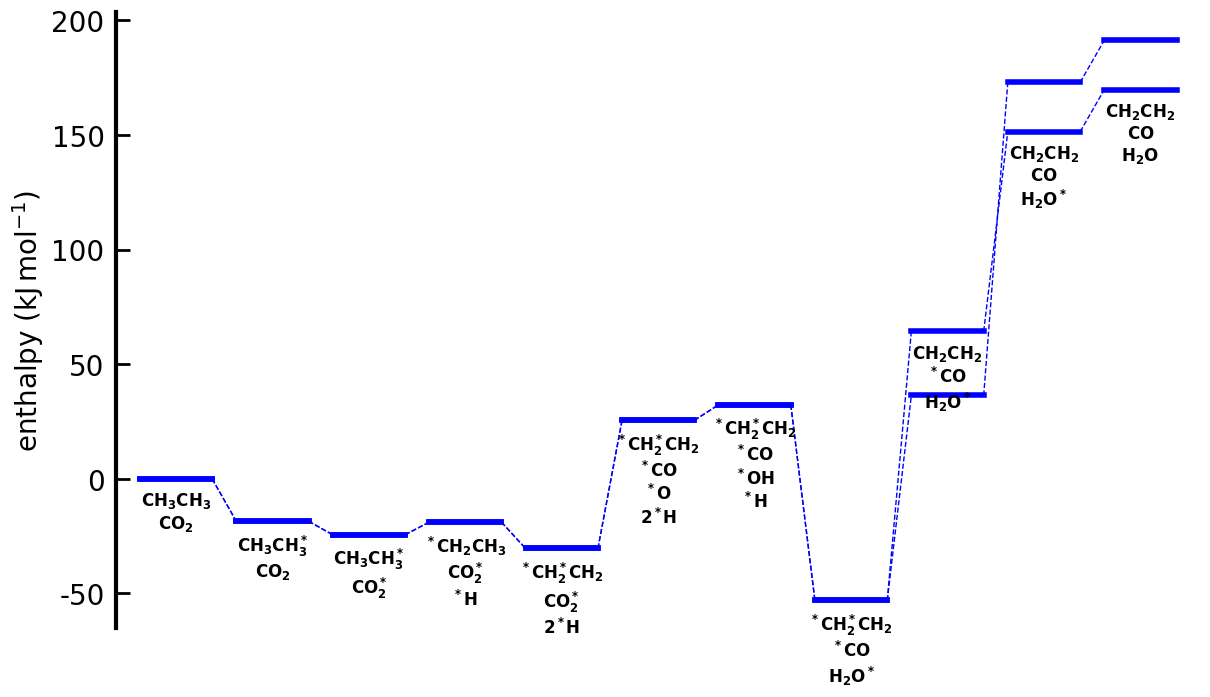

In [43]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

#ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_EOFs=np.zeros(len(system))
    for i, Hf_i in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (Hf_i-system[0], Hf_i-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],Hf_i-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_EOFs[i]=Hf_i-system[0]
    return rel_EOFs

values=ediagram(enthalpies_of_formation)
values=ediagram(enthalpies_of_formation_global)

for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)

# Converting between hypothetical reaction enthalpies based on the species composition matrix

Building the 

In [55]:
# Define the species and their elemental compositions in a dictionary

species = ['CO','C2H4','C2H6X', 'XCH2CH3', 'XO', 'XCH2XCH2', 'XCO', 
           'CO2X', 'XOH', 'H2OX', 'XH', 'X', 'C2H6','H2O', 'CO2']

species_compositions = {
    "X": {"C": 0, "H": 0, "O": 0, "X": 1}, 
    "C2H6": {"C": 2, "H": 6, "O": 0, "X": 0},
    "H2O": {"C": 0, "H": 2, "O": 1, "X": 0},    
    "CO2": {"C": 1, "H": 0, "O": 2, "X": 0},
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "XCH2CH3": {"C": 2, "H": 5, "O": 0, "X": 1},    
    "XO": {"C": 0, "H": 0, "O": 1, "X": 1},
    "XCH2XCH2": {"C": 2, "H": 4, "O": 0, "X": 1},    
    "XCO": {"C": 1, "H": 0, "O": 1, "X": 1},
    "CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "XOH": {"C": 0, "H": 1, "O": 1, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},   
    "XH": {"C": 0, "H": 1, "O": 0, "X": 1},
    "CO": {"C": 1, "H": 0, "O": 1, "X": 0},
    "C2H4": {"C": 2, "H": 4, "O": 0, "X": 0},
}

# species=list(species_compositions.keys())

# Create a matrix to hold the elemental compositions of the target species
num_species = len(species)
num_elements = 4  # C, H, O, X
N = np.zeros((num_species, num_elements))

# Fill in the elemental composition matrix of the target species
for s in species:
    composition = species_compositions[s]
    i = species.index(s)
    N[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N

array([[1., 0., 1., 0.],
       [2., 4., 0., 0.],
       [2., 6., 0., 1.],
       [2., 5., 0., 1.],
       [0., 0., 1., 1.],
       [2., 4., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 2., 1.],
       [0., 1., 1., 1.],
       [0., 2., 1., 1.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [2., 6., 0., 0.],
       [0., 2., 1., 0.],
       [1., 0., 2., 0.]])

Any stoichiometric matrix involving these species can be represented in terms of vectors in the nullspace of $\mathbf{\underline{\underline{N}}}\coloneqq \{\underline{v} : \mathbf{\underline{\underline{N}}}^{\intercal}\underline{v}=\mathbf{\underline{0}}\}$ 

This is a direct consequence of the atomic material balance that must be satisfied for any valid chemical reaction. 

A set of vectors $\mathbf{\underline{\underline{V}}}=\{\mathbf{\underline{v}_i}\}$ where $\mathbf{\underline{v}_i^\intercal\underline{v}_j}=0$ for $i\ne j$ can be obtained through singular-value decomposition of $\mathbf{\underline{\underline{N}}}$, with the set of orthogonal vectors that span the rowspace of $\mathbf{\underline{\underline{N}}}$ associated with zero singular values.

In [72]:
U,s,Vt_ = np.linalg.svd(N.T,full_matrices=True) 
V = Vt_.T[:,len(s):] # picking  values that are associated with zero singular values

As an example, the current stoichiometry matrix $\mathbf{\underline{\underline{S}}}$, has its unique representation in $\mathbf{\underline{\underline{V}}}$ as $\mathbf{\underline{\underline{S}}}=\mathbf{\underline{\underline{V}}}\mathbf{\underline{{w}}}$.

Where $\mathbf{\underline{{w}}}$ can be determined as the projection of $\mathbf{\underline{\underline{S}}}$ onto $\mathbf{\underline{\underline{V}}}$, as $\mathbf{\underline{{w}}}=\mathbf{\underline{\underline{V}}}^\intercal\mathbf{\underline{\underline{S}}}$.

We can define the projection matrix $\mathbf{\underline{\underline{P}}}=\mathbf{\underline{\underline{V}}}^\intercal\mathbf{\underline{\underline{V}}}$ such that $\mathbf{\underline{\underline{S}}}=\mathbf{\underline{\underline{P}}}\mathbf{\underline{\underline{S}}}\therefore (\mathbf{\underline{\underline{I}}}-\mathbf{\underline{\underline{P}}})\mathbf{\underline{\underline{S}}}=\mathbf{\underline{\underline{0}}}$.

The latter is the orthogonal projection of $\mathbf{\underline{\underline{S}}}$ onto the orthogonal complement of $\mathbf{\underline{\underline{V}}}$ which is zero.



See example below.

Text(0.5, 1.0, 'S-PS')

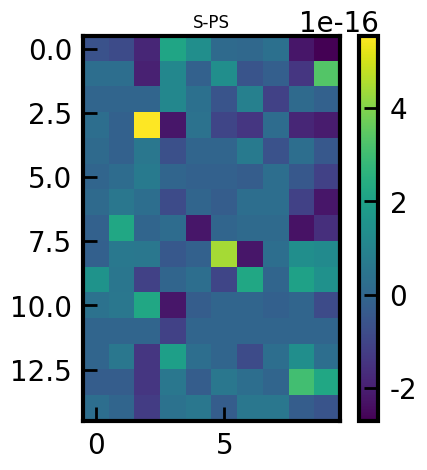

In [83]:
plt.figure(figsize=[5,5])
plt.imshow(S-(B.dot(B.T)).dot(S)); plt.colorbar()
plt.title('S-PS')

This means since any $\mathbf{\underline{\underline{S}}}$ can be represented in terms of $\mathbf{\underline{\underline{V}}}$, $\mathbf{\underline{\underline{V}}}$ itself is a valid stoichiometry matrix, and can be used to derive reaction energies without the need to explicitly define each reaction edge.

Reproducing the steps of the previous section with $\mathbf{\underline{\underline{V}}}$ replacing $\mathbf{\underline{\underline{S}}}$, we have.

We can then calculate the enthalpies of reaction from the BEEF-vdW DFT energies

\begin{equation}
\mathbf{\underline{H}}_{r}=\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{H}}_{f}
\end{equation}


In [86]:
#Calculate the enthalpies of formation
Hrv=V.T.dot(E)
Hrv

array([114.35044557, -32.14329711, -41.82239365,  -6.62057078,
       101.42344661,  -3.57918785,   3.56426475,  23.27415922,
       -70.38735771,  -8.5702404 , -23.95742905])

We select anchor species for each element from the mechanism, in this case $A= C_2H_6, CO, H_2O, Pt(111)$. Since we are creating a local thermochemical network in the DFT energy reference frame, we set the enthalpies of formation of these anchor species to 0. 

In [89]:
#Remove the reference species from the row space
V_A=V[-4:] # these are the reference species
V_hat=V[0:-4] # this is the rest of the stoichiometry matrix

#Array of the enthalpies of formation of the anchor species
Hf_Av =  np.array( [Hf_A_dict[_] for _ in Hf_A_dict.keys()])
Hf_Av

array([   0.   ,  -68.38 , -238.902, -393.11 ])

We can then determine the enthalpies of formation of the target species via 

\begin{align}
      \mathbf{\underline{\hat{H}}}^{A}_{f} & = \left(\mathbf{\underline{\underline{\hat{S}}}}^{\intercal}\right)^+\left(\mathbf{\underline{\underline{S}}}^{\intercal}\mathbf{\underline{E}} - \mathbf{\underline{\underline{S}}}^{A^{\intercal}}\mathbf{\underline{H}}^{A}_{f}\right)
\end{align}


In [93]:
#Calculate the enthalpies of formation of the target species using the pseudo-inverse
Hfv= np.linalg.pinv(V_hat.T).dot(Hrv-V_A.T.dot(Hf_Av))

targets=species-ref_species

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: Hf[i] for i in range(len(targets))}
#Append the enthalpies of formation of the reference species to the enthalpies of formation dictionary
enthalpies_of_formation.update(Hf_A_dict)
enthalpies_of_formation_svd = enthalpies_of_formation

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid e

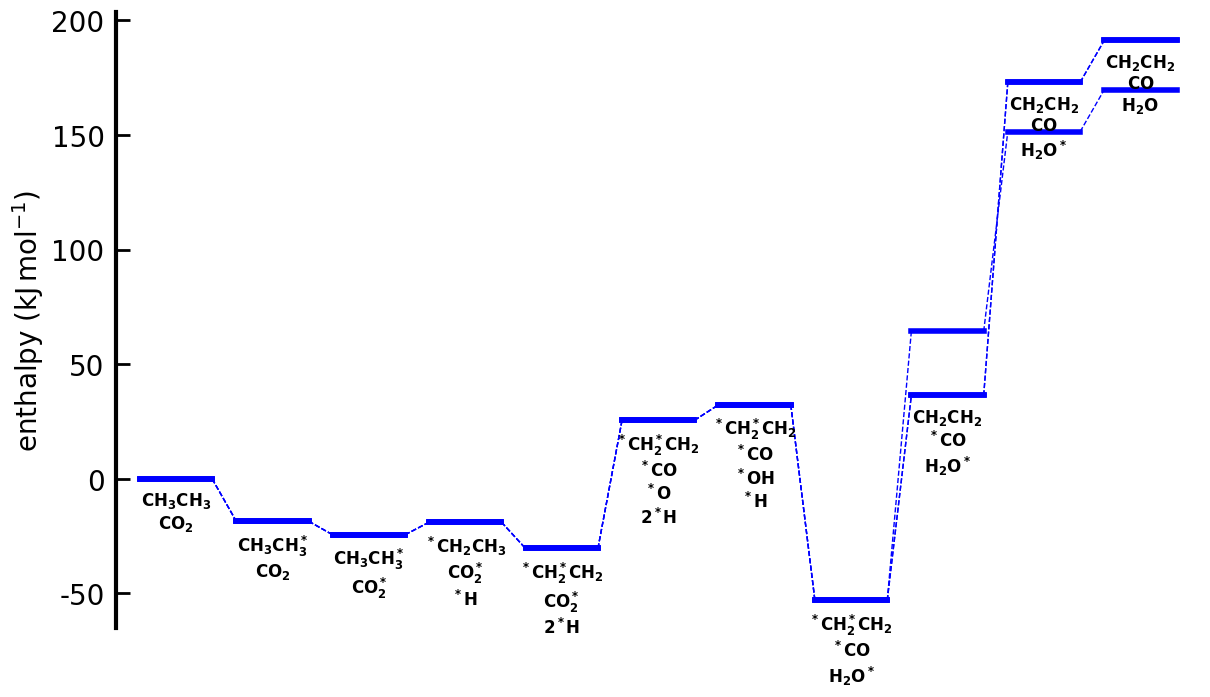

In [94]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

#ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_EOFs=np.zeros(len(system))
    for i, Hf_i in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (Hf_i-system[0], Hf_i-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],Hf_i-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_EOFs[i]=Hf_i-system[0]
    return rel_EOFs

values=ediagram(enthalpies_of_formation)
values=ediagram(enthalpies_of_formation_global)
values=ediagram(enthalpies_of_formation_svd)

for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)